# Looking at CIA World Factbook  

More information on the data contained within the factbook can be found here:
https://www.cia.gov/library/publications/the-world-factbook/

The Factbook contains a compendium of statistics about all of the countries on Earth.  

## Setting up the environment

In [108]:
# Importing packages
import pandas as pd
import sqlite3

# Setting up a connection with the Factbook database
conn = sqlite3.connect("factbook.db")

# Query to get table information
q = "SELECT * FROM sqlite_master WHERE type = 'table';"

# Running the query using pandas
pd.read_sql_query(q, conn)


,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


## Previewing Data

In [109]:
# Query to get the first 5 rows of the table 
q_5 = "SELECT * FROM facts LIMIT 5"

# Running the query using pandas
pd.read_sql_query(q_5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


## Population MIN & MAX

In [110]:
# Query for summary statistics for population and population growth
q_sum = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) from facts"

# Running the query using pandas
pd.read_sql_query(q_sum, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


In [111]:
# Looking at countries with the minimum population 
q_0_pop = "SELECT name FROM facts WHERE population = (SELECT MIN(population) FROM facts)"

# Running the query using pandas
pd.read_sql_query(q_0_pop, conn)

,name
0,Antarctica


In [112]:
# Looking at countries with the maximum population 
q_max_pop = "SELECT name FROM facts WHERE population = (SELECT MAX(population) FROM facts)"

# Running the query using pandas
pd.read_sql_query(q_max_pop, conn)

,name
0,World


## Population Conclusions

The native population of Antarctica is zero, as it is populated entirely by temporary researchers from other countries.  It intuitively would be the country with the lowest population.  

The country with the maximum population isn't a country at all, but rather the population of the Earth.  

## Population Histogram

In [113]:
# Query to get population, population growth, birth and death rates 
q_pop = "SELECT population, population_growth, birth_rate, death_rate FROM facts WHERE (population != (SELECT MIN(population) FROM facts)) AND (population != (SELECT MAX(population) FROM facts))"

# Placing query results into a pandas df
facts_pop = pd.read_sql_query(q_pop, conn)

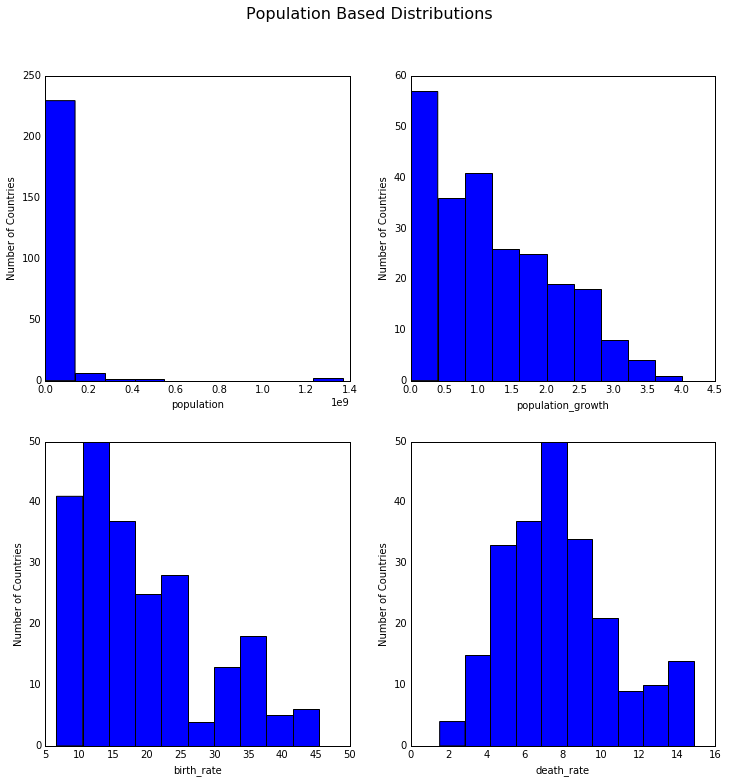

In [114]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline  

# Converting the column names to a list
facts_pop_col = facts_pop.columns.tolist()

# Creating the initial figure
fig = plt.figure(figsize = (12,12))

# Iterating through the column name list and adding a histogram subplot to the figure
for i in range(0,len(facts_pop_col)):
    ax = fig.add_subplot(2,2,i+1)
    ax.hist(facts_pop[facts_pop_col[i]].dropna())
    # Adding a descriptive label to each subplot
    ax.set_xlabel(facts_pop_col[i])
    ax.set_ylabel("Number of Countries")
    # Removing ticks from each subplot
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    
plt.suptitle("Population Based Distributions", fontsize=16) 
plt.show()

## Population Density 

In [115]:
# Query to return the population density (population/land area)
q_pop_den = "SELECT name, CAST(population as float) / CAST(area_land as float) AS population_density FROM facts"
# Assigning query results to a pandas df
pop_den = pd.read_sql_query(q_pop_den, conn)
# Removing null values 
pop_den.dropna(inplace = True)

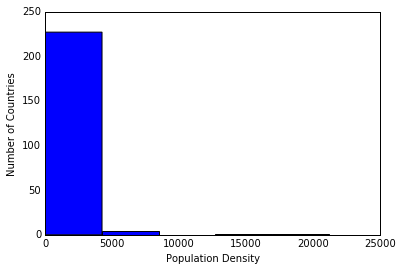

In [116]:
# Creating a histogram based on population density
plt.hist(pop_den["population_density"], bins=5)
plt.xlabel("Population Density")
plt.ylabel("Number of Countries")
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.show()

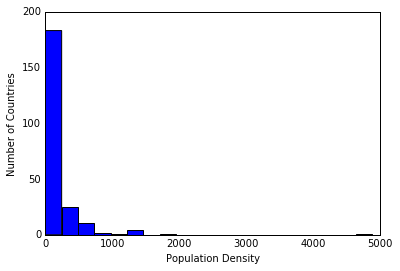

In [117]:
# Creating a histogram based on population density focusing on less than 5000
den_10k = pop_den[pop_den["population_density"]<5000]
plt.hist(den_10k["population_density"], bins=20)
plt.xlabel("Population Density")
plt.ylabel("Number of Countries")
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.show()

In [142]:
# Query to look at land to water ratio by country
q_land_water = "SELECT name, CAST(area_land as float) / CAST(area_water as float) AS land_water_ratio FROM facts"
# Executing query and dropping null values
land_water = pd.read_sql_query(q_land_water, conn).dropna()

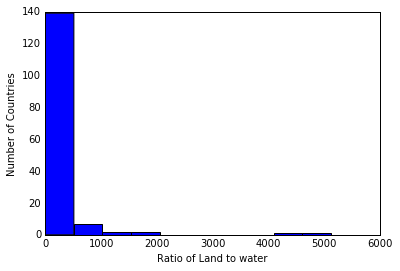

In [143]:
# Histogram of land area to water area 
plt.hist(land_water["land_water_ratio"])
plt.xlabel("Ratio of Land to water")
plt.ylabel("Number of Countries")
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.show()

In [144]:
# Query looking at both land density and population density 
q_land_dens = "SELECT name, CAST(population as float) / CAST(area_land as float) AS population_density, CAST(area_land as float) / CAST(area_water as float) AS land_water_ratio FROM facts WHERE population_density < 2000 AND land_water_ratio < 2000"
land_dens = pd.read_sql_query(q_land_dens, conn).dropna()

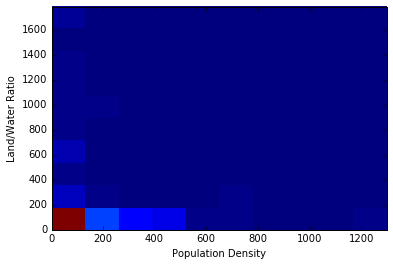

In [145]:
# 2D histogram of land/water ratios and population density for countries less than 2000 for each value
plt.hist2d(land_dens["population_density"], land_dens["land_water_ratio"])
plt.xlabel("Population Density")
plt.ylabel("Land/Water Ratio")
plt.show()

## Water vs. Land

In [146]:
# Query to identify which countries have more water than land
q_more_w = "SELECT name FROM facts WHERE area_water > area_land"
pd.read_sql_query(q_more_w, conn)

,name
0,British Indian Ocean Territory
1,Virgin Islands


In [147]:
# Query to identify the average areas of land and water
q_avg_w = "SELECT AVG(area_water), AVG(area_land), AVG(area) FROM facts WHERE area_water > area_land"
pd.read_sql_query(q_avg_w, conn)

,AVG(area_water),AVG(area_land),AVG(area)
0,27952.0,203.0,28155.0
